# Convert "Standard" ONNX Resnet50 to CoreML
Load an off-the-shelf Resnet50 model for ONNX from [ONNX Model Zoo](https://github.com/onnx/models),  then convert to CoreML, sanity checking the work as we go.

Here's what happens in this notebook:
- Notebook Setup
- ONNX - Load and Validate Model
- O2C - Convert ONNX to CoreML and Validate
- Predictions - generate predictions from both models
- Agreement - briefly compare prediction agreement
- Show selected results


### Links

> [10-Intro-resnet50-convert-compare](10-Intro-resnet50-convert-compare.ipynb) - Intro notebook, contains context for this notebook and a summary of results.  
>
> [20-convert-torch-to-coreml](20-convert-torch-to-corem.ipynb) Notebook for examples of examination and editing of CoreML models.
>
> [40-compare-torch-onnx-coreml](40-compare-torch-onnx-coreml.ipynb) - Notebook for comparisons between these and other models.  
>
> [coreml_help](https://mcsieber.github.io/coreml_help.html) - Documentation for helper module   
>
> [pred_help](https://mcsieber.github.io/pred_help.html) - - - Documentation for helper module  


The cell below is common setup for this and other notebooks. You do have to run it, but you can ignore it otherwise.

In [1]:
# Notebook setup (initially %load(ed) from 'notebook_setup.py')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# mcs utilities and helpers
from ms_util import *

#Project Setup - Names & Commonly Used Values
project_name   = 'compare'   # Used as prefix for several derived names below
model_name     = 'resnet50'
model_arch     = 'Resnet50'   # Resnet50 , Resnet34, etc ...
img_size       = 300
batch_size     = 32

# %run -i {user_lib}/finish_setup.py [--show [Proj Paths Env] | None | All ] 
#
%run -i {user_lib}/finish_setup.py --show proj

data_root       =  /Volumes/ArielD/storage
data_dir        =  /Volumes/ArielD/storage/data
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
project_name    =  compare
proj_data_dir   =  /Volumes/ArielD/storage/data/compare
proj_dir        =  /Users/mcsieber/storage/notebooks/compare
model_name      =  resnet50
model_arch      =  Resnet50
models_dir      =  /Volumes/ArielD/storage/data/compare/models
img_size        =  300
batch_size      =  32



## Additional Setup

In [2]:
from PIL import Image
from PIL import ImageOps
from coreml_help import *
from pred_help import *
mlmodels_dir = data_dir/'mlmodels'
resize_method = Image.NEAREST

#### Test Data - Get and Prepare test images

In [3]:
test_root     = data_root/'data'
test_data_dir = data_dir/'test'
imagenet_dir  = data_dir/'imagenet'
imagenet_path = imagenet_dir/'img_net_labels.txt'

In [4]:
dogcat_dir    = test_root/'dogscats/large/valid-large'
flowers_dir   = test_root/'flowers/data'
fruit_dir     = test_root/'food_poc/data'
food_dir      = Path('/Volumes/ArielD/storage/data/food/images')
pp((dogcat_dir, flowers_dir, food_dir,fruit_dir))

dogcat_dir     =  PosixPath('/Volumes/ArielD/storage/data/dogscats/large/valid-large')
flowers_dir    =  PosixPath('/Volumes/ArielD/storage/data/flowers/data')
food_dir       =  PosixPath('/Volumes/ArielD/storage/data/food/images')
fruit_dir      =  PosixPath('/Volumes/ArielD/storage/data/food_poc/data')


Get random images from various test image sets

In [5]:
ni  = 5           # Get this many images per directory
max_sample = 400  # Max sample range (set limit in case it is a huge directory)
#
t0 = get_rand_images(food_dir,   n_images=int(ni*3), search_limit=max_sample)
t1 = get_rand_images(dogcat_dir, n_images=ni, search_limit=max_sample)
t2 = get_rand_images(flowers_dir,n_images=ni, search_limit=max_sample)
t3 = get_rand_images(fruit_dir,   n_images=ni, search_limit=max_sample)
test_imgs = t0+t1+t2+t3
#
f"{len(test_imgs)} test images"

'29 test images'

Get validation images to sanity check the models as we create or convert them

In [6]:
validation_imgs = [
    Path('/Volumes/ArielD/storage/data/food_poc/data/apples/apple_029.jpg'),
    Path('/Volumes/ArielD/storage/data/compare/data/bana/bana_000.jpg'), ]

#### ImageNet - Read in Labels
These are the [1000 class labels](https://s3.amazonaws.com/onnx-model-zoo/synset.txt) for ImageNet. 

In [7]:
with open(imagenet_path, 'r') as list_ : 
    inet_labels = [line.rstrip() for line in list_ ]
f"{len(inet_labels)} imagenet labels"

'1000 imagenet labels'

#### ImageNet - Calculate Scale and Bias for ONNX and CoreML models
As recommended, input images for the ONNX model are normalized
using the mean and standard deviation for **ImageNet**.
(For details, see Help or Notes for `imagenet_normalize`):

For the CoreML models, we use the values above to calculate an *image scale*
and (Red, Green, Blue) *channel biases* that acheive (almost) the same effect.

In [8]:
mean = np.array(imagenet.mean)
std  = np.array(imagenet.std)

# For CoreML from ONNX, calculate scale and bias to reproduce normalization
ppargs = dict(
    image_scale= 1/(255.0*std.mean()),
    red_bias   = - mean[0]/std[0],
    green_bias = - mean[1]/std[1],
    blue_bias  = - mean[2]/std[2]
)
ppargs

{'image_scale': 0.01735207357279195,
 'red_bias': -2.1179039301310043,
 'green_bias': -2.0357142857142856,
 'blue_bias': -1.8044444444444445}

## ONNX
ONNX - These cells load and check the [ONNX Resnet50(v2)](https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v2/resnet50v2.tar.gz) model. This was downloaded from the [ONNX Model Zoo](https://github.com/onnx/models)

In [9]:
import onnx
import onnxruntime as ort
from onnx_coreml import convert
from coremltools import models as cm

In [10]:
onnxm_name   = 'resnet50.onnx'
onnxm_path   = data_dir/'onnx/resnet50v2'/onnxm_name ; onnxm_path

PosixPath('/Volumes/ArielD/storage/data/onnx/resnet50v2/resnet50.onnx')

In [11]:
onnxm = onnx.load(onnxm_path)
onnx.checker.check_model(onnxm)

#### ONNX Quick Check
Use the model to identify a couple of images that *should* be easily identifiable.  If the model does not categorize these correctly, there is a error of some sort in the setup or downloaded images or downloaded model.

In [12]:
onnx_rt  = ort.InferenceSession(onnxm_path.as_posix())

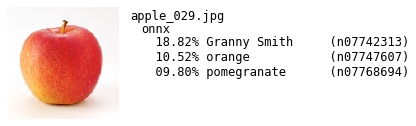

In [13]:
for img_path in validation_imgs:
    pred = pred_for_onnx(onnx_rt,Image.open(img_path),labels=inet_labels)
    if  show_pred(img_path,pred,model_id='onnx') is None: break

### ONNX -> CoreML
O2C - These cells convert the "standard" ONNX Resnet Model from above to a CoreML Model.

In [14]:
o2c_name = 'o2c.mlmodel'
o2c_path = models_dir/o2c_name # This is the CoreML 'spec' path, *NOT* the 'mlmodelc' path
o2c_path

PosixPath('/Volumes/ArielD/storage/data/compare/models/o2c.mlmodel')

In [ ]:
o2c = convert( onnxm,
               image_input_names=['data'],
               preprocessing_args=ppargs );

In [16]:
o2c.save(o2c_path.as_posix())

#### O2C Quick Check
As before, sanity check the model on something easy and obvious

In [17]:
o2c  = cm.MLModel(o2c_path.as_posix())

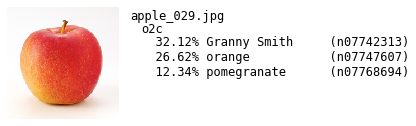

In [18]:
for img_path in validation_imgs:
    img = ImageOps.fit(Image.open(img_path),(224,224), method=resize_method, centering=(0.5,0.4))
    pred = pred_for_o2c(o2c,img,labels=inet_labels)
    if show_pred(img_path, pred, model_id='o2c') is None: break

#### A Note on CoreML naming: 

*"mlmodel"* can be a confusing reference if you are just learning about CoreML.
- The `.mlmodel` *file* is the *protobuf* *spec* for the CoreML model. The name and path above refer to this file. When the *spec* file is loaded into Python, it has a type of `Model_pb2.Model`.
- In Python code,  "MLModel" refers to the `MLModel` Class or an object with this class (ie. the "CoreML model"), *not* the spec.
- When a CoreML model is created (compiled), the model is written to a directory suffixed by `.mlmodelc`


For example, for the model above:

In [19]:
type(o2c)

coremltools.models.model.MLModel

In [20]:
 type(o2c.get_spec())

Model_pb2.Model

When you see a variable with "mlmodel" in the name, it might be referring to the spec, or it might be referring to the CoreML model (the MLModel Class object). You have to check.

## Predictions - Compare Original and Converted Models

Generate a prediction from each of the models for every image. Save the results and compare.  
Specify the models to be included in the results and the parameters needed to run them.  
Then create a [**Classifier**](https://mcsieber.github.io/pred_help.html#pred_help.Classifier) that uses the three models we've instantiated.

In [24]:
params = {
    'onnx' : PredParams( runtime=onnx_rt, func=pred_for_onnx, labels=inet_labels, imgsize=300 ),
    'o2c'  : PredParams( runtime=o2c,     func=pred_for_o2c,   labels=inet_labels, imgsize=224 ),
    # additional models would go here
}

In [25]:
models = Classifier(params, top_count=3)

### Predictions
Make predictions on the test images using each model and save the results


In [ ]:
models.classify(test_imgs);

### Agreement?
How often do the original model and the converted model agree on the top prediction?

In [27]:
ONNX = models.m2i('onnx')  # Model abbr to Model # (index)
O2C  = models.m2i('o2c')
tc   = models.top_classes
tp   = models.top_probs

Create boolen arrays to tabulate those images for which the top classes agree and disagree

In [28]:
pa = tc[ONNX,:,0] == tc[O2C,:,0]

In [29]:
f"ONNX agrees with O2C {pa.sum()} out of {pa.size} images, or {pa.sum()/pa.size:2.2%}" 

'ONNX agrees with O2C 19 out of 29 images, or 65.52%'

## Show Results 
Create a [**Results**](https://mcsieber.github.io/pred_help.html#pred_help.Results) object to show results

In [30]:
results = Results(models);


Showing results [3, 16, 22, 23, 25] 
  and top 2 probabilities for each model


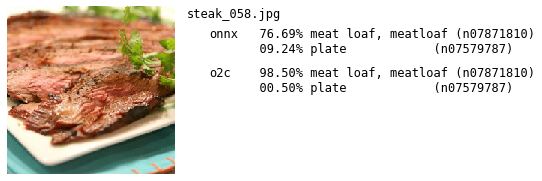

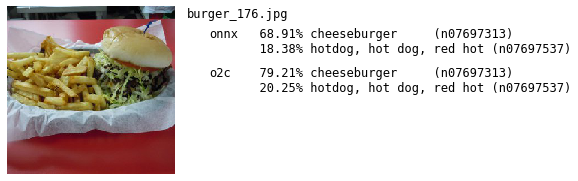

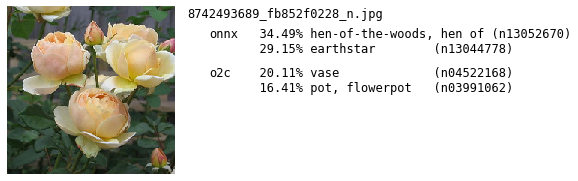

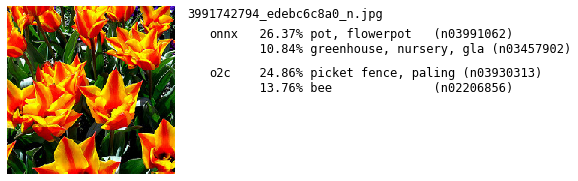

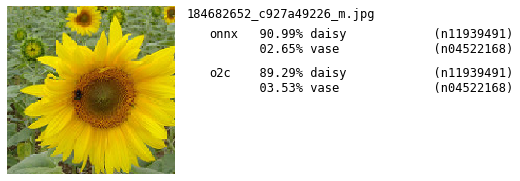

In [31]:
results.show_random()